# Final model training on real data

## Contents

- Load the data
- Preprocessing
- Model
- Training
- Testing the model
    - Model Performance


In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle

from scipy import stats

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
options_path = '../data/real_options_cleaned.csv'

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    return df

In [5]:
options_df = pd.read_csv(options_path, index_col=0)
options_df = reduce_mem_usage(options_df)

In [6]:
options_df = shuffle(options_df, random_state=0)
options_df = options_df.reset_index()
options_df['r'] = options_df['r'] / 100
options_df = options_df.drop('index', axis=1)

In [7]:
options_df

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,type,expiryDate,downloadDate,close,vol,moneyness,tau,r,ba_spread
0,TSLA220506P00945000,2022-04-05 17:43:35,945.0,22.000000,20.203125,22.703125,16.0,25.0,0.602051,put,2022-05-06,2022-04-05,1091.000,0.590332,0.866211,0.085144,0.006832,2.500000
1,NFLX220624C00175000,2022-06-01 17:49:08,175.0,22.625000,21.906250,22.906250,1.0,58.0,0.598633,call,2022-06-24,2022-06-01,192.875,0.660645,1.102539,0.063171,0.011406,1.000000
2,TSLA220520P00700000,2022-05-05 19:58:46,700.0,7.648438,7.000000,7.500000,1621.0,7180.0,0.854004,put,2022-05-20,2022-05-05,873.500,0.694824,0.801270,0.041199,0.008530,0.500000
3,AAPL221021C00300000,2022-03-21 16:59:05+00:00,300.0,0.090027,0.059998,0.119995,50.0,639.0,0.314941,call,2022-10-21,2022-03-21,165.375,0.330078,0.551270,0.587891,0.005409,0.059998
4,NFLX220617C01050000,2022-05-18 19:44:23,1050.0,0.020004,0.000000,0.000000,20.0,0.0,0.500000,call,2022-06-17,2022-06-02,205.125,0.696289,0.195312,0.041199,0.011925,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539590,NFLX220715P00485000,2022-05-04 19:07:40,485.0,284.500000,295.000000,299.500000,100.0,0.0,0.968750,put,2022-07-15,2022-05-25,187.875,0.739258,2.582031,0.140137,0.010719,4.500000
539591,AMZN220520C02740000,2022-05-05 19:40:36,2740.0,5.500000,4.351562,5.351562,50.0,80.0,0.475342,call,2022-05-20,2022-05-05,2328.000,0.671387,0.849609,0.041199,0.008530,1.000000
539592,NVDA230120C00142500,2022-05-04 19:56:26,142.5,73.000000,71.125000,74.250000,36.0,1108.0,0.592773,call,2023-01-20,2022-05-04,203.375,0.664551,1.426758,0.716797,0.008331,3.125000
539593,NVDA221021C00260000,2022-06-02 19:39:24,260.0,5.621094,0.000000,0.000000,34.0,0.0,0.125000,call,2022-10-21,2022-06-02,195.875,0.824707,0.753418,0.387451,0.011925,0.000000


# Preprocessing

The preprocessing phase consist in the following steps

- remove all the columns in the dataset that are not going to be use as the neural net's input
- hot-encode all the dummy variables, which in this case, is the `type` feature
- Standardize the input and the output data

The training dataset will made of 80% of the total data, while the validation and the test set are going to represent 10% of the total data.

In [8]:
cols_to_drop = ['impliedVolatility',
                  'bid',
                  'ask',
                  'volume',
                  'openInterest',
                  'contractSymbol',
                  'lastTradeDate',
                    'ba_spread',
                  'expiryDate',
                  'downloadDate']
options_df = options_df.drop(cols_to_drop, axis=1)
options_df = pd.get_dummies(options_df, prefix='', prefix_sep='')

In [9]:
input_sc = StandardScaler()
output_sc = StandardScaler()
input_data = input_sc.fit_transform(options_df.drop(['lastPrice'], axis=1))
output_data = output_sc.fit_transform(options_df['lastPrice'].values.reshape(-1, 1))

train_size = 0.8
val_size = 0.1

last_train_idx = int(np.round(len(input_data) * train_size))
last_val_idx = last_train_idx + int(np.round(len(input_data) * val_size))

X_train = input_data[0:last_train_idx]
X_val = input_data[last_train_idx:last_val_idx]
X_test = input_data[last_val_idx:]

y_train = output_data[0:last_train_idx]
y_val = output_data[last_train_idx:last_val_idx]
y_test = output_data[last_val_idx:]

In [11]:
X_train = Variable(torch.Tensor(X_train))
X_val = Variable(torch.Tensor(X_val))
X_test = Variable(torch.Tensor(X_test))

y_train = Variable(torch.Tensor(y_train))
y_val = Variable(torch.Tensor(y_val))
y_test = Variable(torch.Tensor(y_test))

# Model

The deep learning model is a fully connected neural network with the following architecture:

- 4 hidden layers
- 800 neurons for each layer
- $LeakyReLU$ used as activation function
- a residual connection every two hidden layers (helps to stabilize the gradient)

The values of these hyperparameters are being obtained after executing the Bayesian Optimization.

The weights of the network are initialized using the Glorot uniform distribution described in *Understanding the difficulty of training deep feedforward neural networks* - Glorot, X. & Bengio, Y. (2010)

In [12]:
CUDA = torch.cuda.is_available()
device = 'cuda:0' if CUDA else 'cpu'

In [13]:
class ResBlock(nn.Module):

  def __init__(self, module):
    super(ResBlock, self).__init__()
    self.module = module

  def forward(self, x):
    return self.module(x) + x

In [14]:
class HiddenLayer(nn.Module):

  def __init__(self, layer_size, act_fn):
      super(HiddenLayer, self).__init__()
      
      if act_fn == 'ReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ReLU())
      elif act_fn == 'LeakyReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.LeakyReLU())
      elif act_fn == 'ELU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ELU())
    
  def forward(self, x):
    return self.layer(x)

In [15]:
class Net(nn.Module):

  def __init__(self, input_size, output_size, hidden_size, num_layers, act_fn):
    super(Net, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size

    if act_fn == 'ReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ReLU())
    elif act_fn == 'LeakyReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.LeakyReLU())
    elif act_fn == 'ELU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ELU())

    self.hidden_layers_list = []

    for i in range(num_layers // 2):
      self.hidden_layers_list.append(
          ResBlock(
            nn.Sequential(
                HiddenLayer(self.hidden_size, act_fn),
                HiddenLayer(self.hidden_size, act_fn)
            )
        )
      )

    self.hidden_layers = nn.Sequential(*self.hidden_layers_list)

    self.net = nn.Sequential(
        self.initial_layer,
        self.hidden_layers,
        nn.Linear(self.hidden_size, self.output_size)
    )
  
  def forward(self, x):
    return self.net(x)

In [16]:
def init_weights(m, init_m: str):

  @torch.no_grad()
  def init_uniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_normal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xuniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xnormal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_normal_(m.weight)
      m.bias.data.fill_(0.01)

  if init_m == 'uniform':
    m.apply(init_uniform)
  elif init_m == 'normal':
    m.apply(init_normal)
  elif init_m == 'xaiver uniform':
    m.apply(init_xuniform)
  elif init_m == 'xavier normal':
    m.apply(init_xnormal)

# Training

Regarding the training phase the number of max epochs is set to 2000, but since running 2000 epochs could (as well as take a long time) **overfit** the neural network, an *Early Stopping* technique was used to stop the neural network training if the validation error no longer improves. In particular, if for 20 epochs the validation error does not improve with respect to the minimum obtained then the training is stopped.

The loss function used to train the neural net is the Mean squared error.

In [17]:
input_size = 8
output_size = 1
num_layers = 4
hidden_size = 800
batch_size = 774
epochs = 2000
lr = 5.973524887918111e-05
init_method = 'xaiver uniform'
act_fn = 'LeakyReLU'

model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
init_weights(model, init_method)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
model = model.to(device)

In [19]:
class OptDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return len(self.X)

### Losses Metrics

In [20]:
def MAPELoss(output, target):
  return torch.mean(torch.abs((target - output) / target))

In [21]:
def evaluate(model, loss_fn, X_val, y_val):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch, batch_labels in DataLoader(OptDataset(X_val, y_val), batch_size=batch_size):
            out = model(batch.to(device))
            loss = loss_fn(out, batch_labels.to(device))
            losses.append(loss.item())

    losses = np.array(losses)
    print('\nVal set: Average loss: {:.8f}\n'.format(
                losses.mean()))
    return losses.mean()

### Early Stopping class

In [22]:
# Code took form: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, 
                 patience=10, 
                 verbose=False, 
                 delta=0, 
                 path='../models/final_heston_model.chkpt',
                 trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Train Loop

In [23]:
def train(
    epochs,
    batch_size,
    model,
    optimizer,
    loss_fn,
    X_train,
    y_train,
    X_val,
    y_val
):

  training_losses = []
  validation_losses = []

  early_stopping = EarlyStopping(patience=20)

  for epoch in range(epochs):
    model.train()
    epoch_losses = []
    total_loss = 0
    start_time = time.time()
    i = 0

    for batch, batch_labels in DataLoader(OptDataset(X_train, y_train), batch_size=batch_size):
      out = model(batch.to(device))
      optimizer.zero_grad()

      loss = loss_fn(out, batch_labels.to(device))
      epoch_losses.append(loss.item())
      total_loss += loss.item()
      loss.backward()
      optimizer.step()

      if i > 0 and i % 50 == 0:
        avg_loss = total_loss / 50
        elapsed = time.time() - start_time
        print('| Epoch {:3d} | {:5d}/{:5d} batches | lr {:2.5f} | ms/batch {:5.2f} | '
                  'loss {:5.8f}'.format(
              epoch, i, len(X_train) // batch_size+1, lr, elapsed * 1000 / 50,
              avg_loss))
        start_time = time.time()
        total_loss = 0

      i += 1

    training_losses.append(np.array(epoch_losses).mean())
    val_loss = evaluate(model, loss_fn, X_val, y_val)
    validation_losses.append(val_loss)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print(f"Stopping at Epoch: {epoch}")
        break

  return training_losses, validation_losses

In [24]:
load = False
save_model_path = '../models/final_real_data_model_cleaned.chkpt'
val_err_df_path = '../results/val_final_real_data_model_cleaned.csv'

if not load:
  train_losses, val_losses = train(
      epochs,
      batch_size,
      model,
      optimizer,
      loss_fn,
      X_train,
      y_train,
      X_val,
      y_val)
  val_err_df = pd.DataFrame({
      'Training': train_losses,
      'Validation': val_losses})
  val_err_df.to_csv(val_err_df_path)
  torch.save(model.state_dict(), save_model_path)
else:
  model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
  model.load_state_dict(torch.load(save_model_path, map_location=device))
  model = model.to(device)
  val_err_df = pd.read_csv(val_err_df_path, index_col=0)

| Epoch   0 |    50/  558 batches | lr 0.00006 | ms/batch 17.30 | loss 0.37621312
| Epoch   0 |   100/  558 batches | lr 0.00006 | ms/batch 15.69 | loss 0.12560805
| Epoch   0 |   150/  558 batches | lr 0.00006 | ms/batch 14.10 | loss 0.08252220
| Epoch   0 |   200/  558 batches | lr 0.00006 | ms/batch 15.80 | loss 0.08641968
| Epoch   0 |   250/  558 batches | lr 0.00006 | ms/batch 18.01 | loss 0.07730174
| Epoch   0 |   300/  558 batches | lr 0.00006 | ms/batch 15.54 | loss 0.07943854
| Epoch   0 |   350/  558 batches | lr 0.00006 | ms/batch 16.82 | loss 0.07612933
| Epoch   0 |   400/  558 batches | lr 0.00006 | ms/batch 17.18 | loss 0.07528757
| Epoch   0 |   450/  558 batches | lr 0.00006 | ms/batch 15.46 | loss 0.07570924
| Epoch   0 |   500/  558 batches | lr 0.00006 | ms/batch 14.83 | loss 0.07461556
| Epoch   0 |   550/  558 batches | lr 0.00006 | ms/batch 16.44 | loss 0.06511319

Val set: Average loss: 0.07375153

| Epoch   1 |    50/  558 batches | lr 0.00006 | ms/batch 15.0

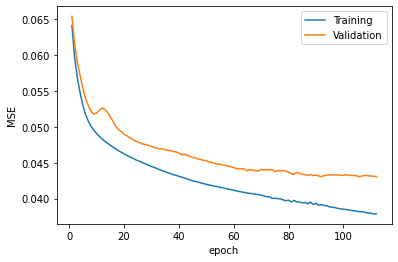

In [25]:
val_err_df[1:].plot(xlabel='epoch', ylabel='MSE')
plt.plot();

# Test the model

Now that the model has been trained, let's verify the accuracy of the model's prediction on a small sample of the test set.

In [26]:
model.eval();

In [27]:
test_size = 30

with torch.no_grad():
    test_out = model(X_test[0:test_size].to(device))

test_out = output_sc.inverse_transform(test_out.cpu().detach().numpy())
real_out = output_sc.inverse_transform(y_test[0:test_size].cpu().detach().numpy())

In [28]:
cols = ['strike', 'close', 'hv_21', 'moneyness', 'tau', 'r',
       'call', 'put']
test_options = pd.DataFrame(input_sc.inverse_transform(X_test[0:test_size].detach().cpu().numpy()), columns=cols)

In [29]:
test_options['Prediction'] = test_out
test_options['Real'] = real_out
test_options

,strike,close,hv_21,moneyness,tau,r,call,put,Prediction,Real
0,175.201843,186.992081,0.464006,0.936050,0.895458,0.008430,0.000215,0.999785,25.539783,25.428410
1,1079.995117,2433.269287,0.594730,0.443467,0.120853,0.011406,0.000215,0.999785,-3.084072,0.834347
2,1575.103271,977.128235,0.605451,0.620090,0.159154,0.008148,1.000080,-0.000080,63.846516,3.311031
3,2223.874268,876.535767,0.712410,0.394227,1.739545,0.008331,1.000080,-0.000080,89.246368,74.011772
4,135.148193,198.905624,0.600590,0.678965,0.021910,0.011925,0.000215,0.999785,-1.391178,0.027981
5,3300.873779,2404.062012,0.592800,0.728562,0.469732,0.011437,1.000080,-0.000080,47.022457,43.801968
6,104.984261,175.847183,0.742214,0.596897,1.104147,0.009094,0.000215,0.999785,9.689625,3.887005
7,2380.133057,2145.807373,0.751469,1.109373,0.002760,0.010322,0.000215,0.999785,212.467499,223.390488
8,260.254150,208.128983,0.823657,1.248085,0.041306,0.008529,0.000215,0.999785,53.521835,51.865593
9,239.980042,274.614197,0.383385,0.874500,2.060680,0.011925,0.000215,0.999785,35.975079,27.559513


In [30]:
test_options['Abs Error'] = np.abs(test_options.Prediction - test_options.Real)

In [31]:
test_options.sort_values('Abs Error')

,strike,close,hv_21,moneyness,tau,r,call,put,Prediction,Real,Abs Error
0,175.201843,186.992081,0.464006,0.936050,0.895458,0.008430,0.000215,0.999785,25.539783,25.428410,0.111374
12,3110.989502,2082.012207,0.748074,1.494287,0.008407,0.010880,0.000215,0.999785,882.825684,883.340881,0.515198
21,159.872681,259.626221,0.462862,0.616879,0.065858,0.010880,0.000215,0.999785,0.675503,0.085583,0.589920
4,135.148193,198.905624,0.600590,0.678965,0.021910,0.011925,0.000215,0.999785,-1.391178,0.027981,1.419159
8,260.254150,208.128983,0.823657,1.248085,0.041306,0.008529,0.000215,0.999785,53.521835,51.865593,1.656242
20,244.924988,183.917618,0.498456,1.331223,0.063402,0.008232,0.000215,0.999785,64.861458,62.261913,2.599545
24,1190.142700,724.506165,0.807647,0.609029,0.011107,0.010749,1.000080,-0.000080,2.680576,0.027981,2.652596
14,585.134155,177.384415,1.558969,0.303952,0.104404,0.009094,1.000080,-0.000080,2.687397,0.027981,2.659416
28,104.984261,165.855179,0.358512,0.632579,0.871152,0.008331,0.000215,0.999785,5.860485,3.023044,2.837441
5,3300.873779,2404.062012,0.592800,0.728562,0.469732,0.011437,1.000080,-0.000080,47.022457,43.801968,3.220490


## Model Performance

Let's now test the model's accuracy on different sets (training, validation and testing) using different loss metrics.

### MSE (Mean squared error)

$$
MSE = \frac{1}{n} \sum (y_i - \hat{y}_i)^2
$$

In [32]:
def get_mse(model, X, y, batch_size):
    losses = []
    with torch.no_grad():
        for batch, batch_labels in DataLoader(OptDataset(X, y), batch_size=batch_size):
            out = model(batch.to(device))
            loss = loss_fn(out, batch_labels.to(device))
            losses.append(loss.item())

    losses = np.array(losses)
    return losses

In [33]:
model.eval()

print('The MSE on the train set is: ', get_mse(model, X_train, y_train, batch_size).mean())
print('The MSE on the val set is: ', get_mse(model, X_val, y_val, batch_size).mean())
print('The MSE on the test set is: ', get_mse(model, X_test, y_test, batch_size).mean())

The MSE on the train set is:  0.0382613068176133
The MSE on the val set is:  0.043078656042260785
The MSE on the test set is:  0.03890983129718474


### MAE (Mean absolute error)

$$
MAE = \frac{1}{n} \sum |y_i - \hat{y}_i |
$$

In [34]:
def get_mae(model, X, y, batch_size):
    mae_loss = nn.L1Loss()
    losses = []
    with torch.no_grad():
        for batch, batch_labels in DataLoader(OptDataset(X, y), batch_size=batch_size):
            out = model(batch.to(device))
            loss = mae_loss(out, batch_labels.to(device))
            losses.append(loss.item())

    losses = np.array(losses)
    return losses

In [35]:
model.eval()

print('The MAE on the train set is: ', get_mae(model, X_train, y_train, batch_size).mean())
print('The MAE on the val set is: ', get_mae(model, X_val, y_val, batch_size).mean())
print('The MAE on the test set is: ', get_mae(model, X_test, y_test, batch_size).mean())

The MAE on the train set is:  0.06676574439264327
The MAE on the val set is:  0.06912885052817208
The MAE on the test set is:  0.0682397718408278


### RSME (Root mean squared error)

$$
RSME = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum (y_i - \hat{y}_i)^2}
$$

In [36]:
model.eval()

print('The RMSE on the train set is: ', np.sqrt(get_mse(model, X_train, y_train, batch_size)).mean())
print('The RMSE on the val set is: ', np.sqrt(get_mse(model, X_val, y_val, batch_size)).mean())
print('The RMSE on the test set is: ', np.sqrt(get_mse(model, X_test, y_test, batch_size)).mean())

The RMSE on the train set is:  0.19248191089536268
The RMSE on the val set is:  0.2047474972882962
The RMSE on the test set is:  0.1941669850142239


### MAPE (Mean absolute percentage error)

$$
MAPE = \frac{1}{n} \sum \frac{|y_i - \hat{y}_i|}{y_i}
$$

In [37]:
def get_mape(model, X, y, batch_size):
    losses = []
    with torch.no_grad():
        for batch, batch_labels in DataLoader(OptDataset(X, y), batch_size=batch_size):
            out = model(batch.to(device))
            loss = MAPELoss(out, batch_labels.to(device)).detach().cpu().item()
            losses.append(loss)

    return np.array(losses)

In [38]:
model.eval()

print('The MAPE on the train set is: ', get_mape(model, X_train, y_train, batch_size).mean())
print('The MAPE on the val set is: ', get_mape(model, X_val, y_val, batch_size).mean())
print('The MAPE on the test set is: ', get_mape(model, X_test, y_test, batch_size).mean())

The MAPE on the train set is:  0.5852175291667703
The MAPE on the val set is:  0.7770054436155728
The MAPE on the test set is:  0.5997079587408475


### $R^2$

In [39]:
from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    out = model(X_test[0:batch_size].to(device)).squeeze().cpu().detach().numpy()

y_true = y_test[0:batch_size].cpu().squeeze().detach().numpy()

r2 = r2_score(y_pred=out, y_true=y_true)

print('the R^2 score is: ', r2)

the R^2 score is:  0.9477473351615887


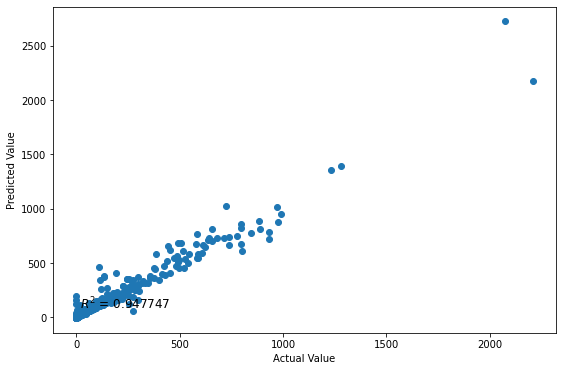

In [40]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()

ax.scatter(
    y=output_sc.inverse_transform(out.reshape(-1, 1)),
    x=output_sc.inverse_transform(y_true.squeeze().reshape(-1, 1))
)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')

ax.text(20, 80, f'$R^2$ = {np.round(r2, 6)}', fontsize=12)

plt.show()